In [324]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import urllib.request

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import numpy as np
import matplotlib.pyplot as plt
from discretize import TreeMesh
from discretize.utils import mkvc

# sphinx_gallery_thumbnail_number = 3

In [325]:

import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

# from SimPEG.potential_fields import magnetics
# from SimPEG import dask
# from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

In [326]:
import os
import urllib.request
import tarfile

# Enlace de Google Drive (modificado para descarga directa)
data_source = "https://drive.google.com/uc?export=download&id=1NqTIcpDfc2JSTDuajIogok7iQFoG2nAM"

# Descargar el archivo y guardar el nombre local
downloaded_data = "Inversion_Datos_Andes.tar.gz"
print(f"Downloading data from: {data_source}")
urllib.request.urlretrieve(data_source, downloaded_data)
print(f"File downloaded: {downloaded_data}")

# Descomprimir el archivo .tar.gz
if tarfile.is_tarfile(downloaded_data):
    with tarfile.open(downloaded_data, "r:gz") as tar:
        # Extraer los archivos al directorio actual
        tar.extractall()
    print("Files extracted.")
else:
    print("The downloaded file is not a tar.gz file.")

# Definir el directorio que contiene los datos descomprimidos
dir_path = os.path.join("Inversion_Datos_Andes", "")  # Ruta a la carpeta descomprimida

# Nombres de los archivos con rutas completas
topo_filename = os.path.join(dir_path, "Topo_80k_puntos_Andes.txt")
data_filename = os.path.join(dir_path, "Dato_obs_20k_puntos_Andes_Sup.txt")

# Verificación de los archivos
if os.path.exists(topo_filename):
    print(f"Topo file located: {topo_filename}")
else:
    print(f"Topo file not found: {topo_filename}")

if os.path.exists(data_filename):
    print(f"Data file located: {data_filename}")
else:
    print(f"Data file not found: {data_filename}")

File downloaded: Inversion_Datos_Andes.tar.gz
Files extracted.
Topo file located: Inversion_Datos_Andes\Topo_80k_puntos_Andes.txt
Data file located: Inversion_Datos_Andes\Dato_obs_20k_puntos_Andes_Sup.txt


In [327]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))
xyz_topo

array([[853600.11 , 987505.628,   2272.   ],
       [853610.11 , 987505.628,   2275.   ],
       [853620.11 , 987505.628,   2275.   ],
       ...,
       [856560.11 , 989125.628,   2711.   ],
       [856570.11 , 989125.628,   2714.   ],
       [856580.11 , 989125.628,   2716.   ]])

In [328]:
# Load field data
dobs = np.loadtxt(str(data_filename))
dobs

array([[ 8.53600102e+05,  9.87505628e+05,  2.80000000e+03,
        -2.88567400e-01],
       [ 8.53610102e+05,  9.87505628e+05,  2.80000000e+03,
        -2.96634700e-01],
       [ 8.53620102e+05,  9.87505628e+05,  2.80000000e+03,
        -3.05116500e-01],
       ...,
       [ 8.55560102e+05,  9.88625628e+05,  2.80000000e+03,
         4.06308000e-01],
       [ 8.55570102e+05,  9.88625628e+05,  2.80000000e+03,
         3.95532100e-01],
       [ 8.55580102e+05,  9.88625628e+05,  2.80000000e+03,
         3.80421800e-01]])

In [329]:
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

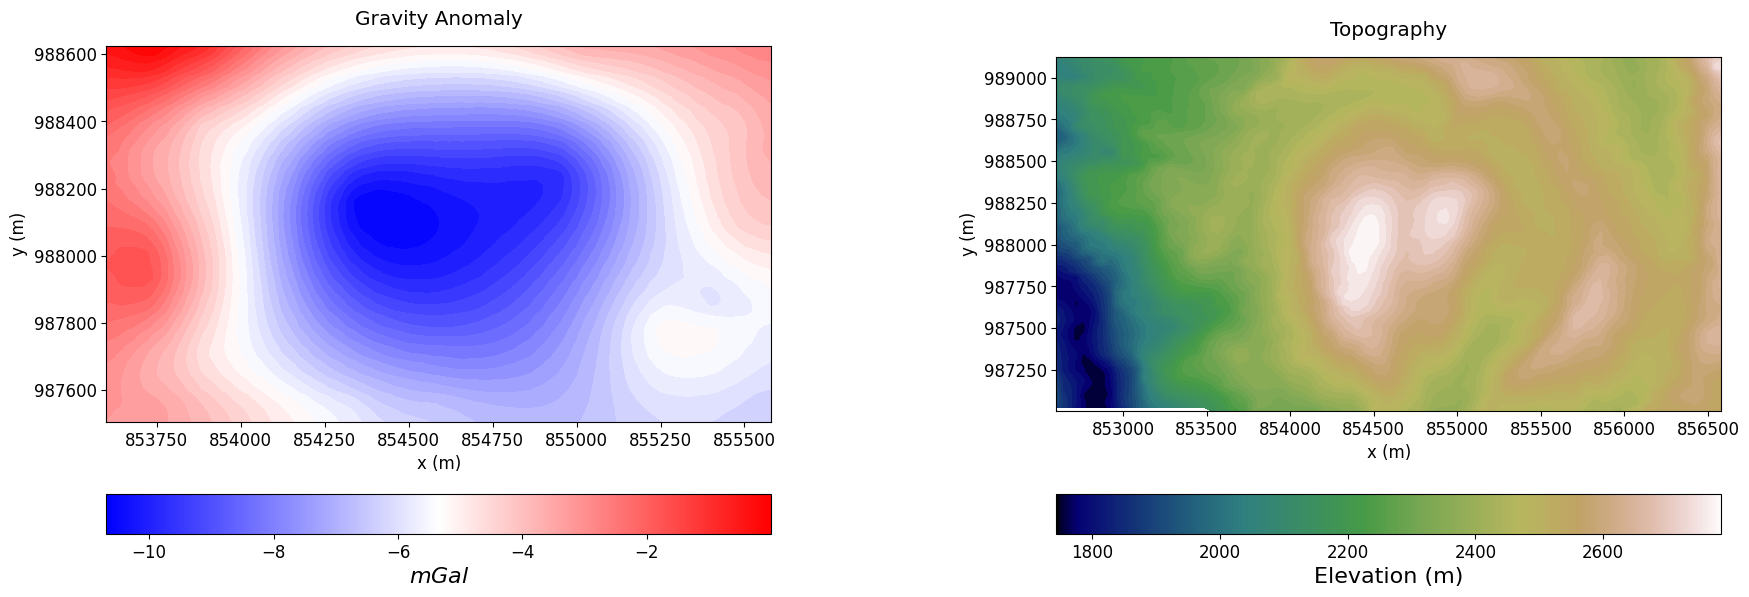

In [330]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# # Normalización de los datos de 'dobs' para el rango de -16 a 8
# norm = mpl.colors.Normalize(vmin=-9, vmax=-1)
# dobs_normalized = norm(dobs)  # Normalización de los datos
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Primer gráfico: Anomalía de gravedad
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

# Usar el método plot2Ddata() para plotear los datos
# Asumiendo que plot2Ddata es una función definida previamente
# Asegúrate de que esta función reciba correctamente los datos normalizados.
plot2Ddata(
    receiver_locations,
    dobs,  # Usamos los datos normalizados
    ax=ax1,
    dataloc=False,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.35, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=-np.min(np.abs(dobs)))
# Usar la normalización para la barra de colores
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

# Segundo gráfico: Topografía
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],  # Coordenadas X, Y de la topografía
    xyz_topo[:, -1],    # Altura de la topografía (Z)
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)

ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.35, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("Elevation (m)", size=16)

# Mostrar el gráfico
plt.show()


In [331]:
#Definir desviación estandar de nuestros datos, en este caso, será de 1
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.01 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.106861973


In [332]:
# Definir los receptores (con los puntos XYZ). Los datos consisten en mediciones de anomalías verticales de gravedad. 
# El conjunto de receptores debe definirse como una lista.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Definir el campo de la fuente
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define el survey (sondeo)
survey = gravity.survey.Survey(source_field)

In [333]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=-dobs, standard_deviation=uncertainties)

<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

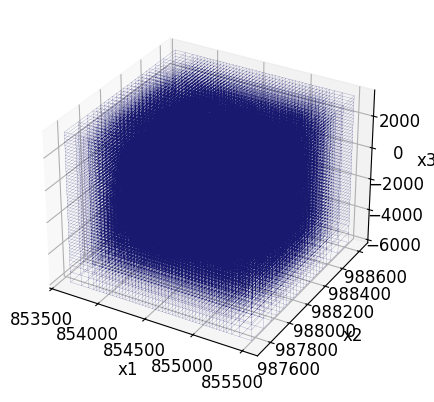

In [334]:
#definir la malla
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])

                           
mesh.plot_grid(color="midnightblue", linewidth=0.1)

In [335]:
#Modelo inicial/de referencia y mapeo en la malla tensorial
#Creamos el modelo de partida para la inversión desde el espacio del modelo a las celdas vacías
#Los modelos de partida y de referencia pueden ser un valor de fondo constante

# Encuentra los índices de las celdas activas en el modelo de avance (las que están por debajo de la superficie)
active_tensor_cells = active_from_xyz(mesh, xyz_topo)

# Definir la asignación del modelo a las celdas activas
n_tensor_active = int(active_tensor_cells.sum())

#Mapping from the Model to Active Cells
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)  #El modelo consiste en un valor para cada celda activa


In [336]:
# Definir y trazar el modelo inicial
# block_density = -0.2
starting_tensor_model = 1e-4 * np.ones(n_tensor_active)
# reference_tensor_model = np.zeros_like(starting_tensor_model)

In [337]:
# starting_tensor_model

# ind_block = (
#     (mesh.gridCC[active_tensor_cells, 0] > 854236)
#     & (mesh.gridCC[active_tensor_cells, 0] < 855146)
#     & (mesh.gridCC[active_tensor_cells, 1] > 987813)
#     & (mesh.gridCC[active_tensor_cells, 1] < 988145)
#     & (mesh.gridCC[active_tensor_cells, 2] > -4000)
#     & (mesh.gridCC[active_tensor_cells, 2] < 200)
# )
# starting_tensor_model[ind_block] = block_density

reference_tensor_model = np.zeros_like(starting_tensor_model)

In [338]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

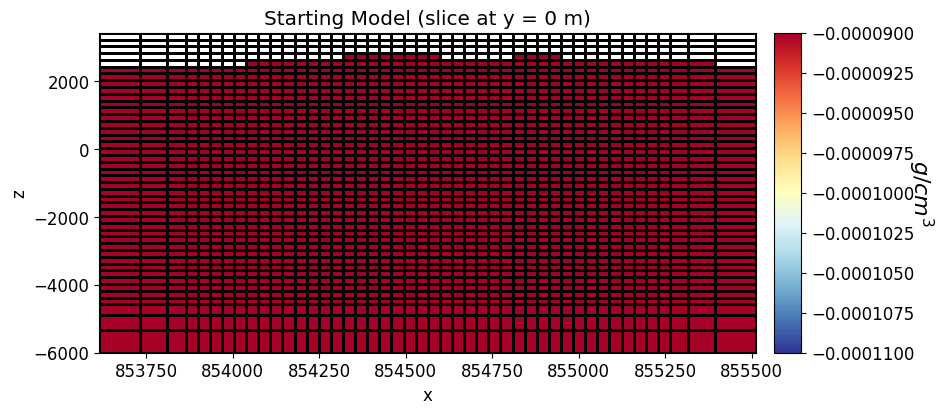

In [339]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


# norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(starting_tensor_model)), vmax=-np.min(np.abs(starting_tensor_model))
    )

mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [340]:
#Definimos la física del problema de la gravedad utilizando la clase de simulación.
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
)

In [341]:
#Definición del problema inverso

# Definir el desajuste de datos. Aquí el desajuste de datos es la norma L2 del residuo 
# ponderado entre los datos observados y los datos predichos para un modelo dado.
# Dentro del desajuste de datos, el residuo entre los datos predichos y observados son
# normalizados por la desviación estándar de los datos.
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)
dmis_L2.W = utils.sdiag(1 / uncertainties)



# Definir la regularización (función objetivo del modelo).

reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_tensor_cells,
    mapping=tensor_model_map,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=10.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
)

# reg_L2 = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=active_tensor_cells,
#     mapping=tensor_model_map,
#     alpha_s=1e-5, 
#     alpha_x=1/5, 
#     alpha_y=1/5, 
#     alpha_z=1/3, 
#     alpha_xx=1/5, 
#     alpha_yy=1/5, 
#     alpha_zz=1/3,
#     reference_model=reference_tensor_model, 
#     reference_model_in_smooth=True, 

# )



In [342]:
# Definir cómo se resuelve el problema de optimización. Aquí vamos a utilizar un enfoque
# Gauss-Newton proyectado que emplea el solucionador de gradiente conjugado.
opt_L2 = optimization.InexactGaussNewton(
           maxIter=85, maxIterLS=30, maxIterCG=30, tolCG=1e-3
)
# opt_L2 = optimization.ProjectedGNCG(
#     maxIter=60,
#     lower=2.0,
#     upper=-2.0,
#     maxIterLS=30,
#     maxIterCG=50,
#     tolCG=1e-3,
# )

In [343]:
# Aquí definimos el problema inverso que hay que resolver
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [344]:
# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration()
save_iteration.outDict = {}

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False, 
                                                          threshold_value=1e-12, 
                                                          threshold_method='amplitude', 
                                                          normalization_method='maximum')

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True) #Importante XDDDD
# Definir un valor inicial para el parámetro de compensación (beta) entre el 
# desajuste de los datos y la regularización.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=20)
# Taza de diminución del valor de Beta
beta_schedule = directives.BetaSchedule(coolingFactor=10.0, coolingRate=2) 

target_misfit = directives.TargetMisfit(chifact=0.01)



# The directives are defined as a list.
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
]



In [345]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.26e-01  5.85e+07  5.05e+00  5.85e+07    4.29e+06      0              


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  4.26e-01  1.09e+07  2.18e+07  2.02e+07    2.74e+01      0              
   2  4.26e-02  1.09e+07  2.18e+07  1.18e+07    1.04e+06      0   Skip BFGS  
   3  4.26e-02  2.67e+06  8.34e+07  6.22e+06    9.66e+00      0              
   4  4.26e-03  2.67e+06  8.34e+07  3.02e+06    2.45e+05      1   Skip BFGS  
   5  4.26e-03  7.07e+05  2.13e+08  1.61e+06    5.11e+00      0              
   6  4.26e-04  7.07e+05  2.13e+08  7.98e+05    4.20e+04      0   Skip BFGS  
   7  4.26e-04  3.04e+05  5.19e+08  5.25e+05    3.87e+02      0              
   8  4.26e-05  3.04e+05  5.19e+08  3.26e+05    7.44e+03      0              
   9  4.26e-05  1.08e+05  2.11e+09  1.98e+05    3.46e+03      0              
  10  4.26e-06  1.03e+05  2.09e+09  1.11e+05    2.01e+03      0              
  11  4.26e-06  4.50e+04  5.47e+09  6.83e+04    6.19e+03      0              
  12  4.26e-07  3.78e+04  5.61e+09  4.02e+04    1.64e+03      0              
  13  4.26e-07  2.83e+04  8.34e+09  3.18e+04    3.52e+03      0 

KeyboardInterrupt: 

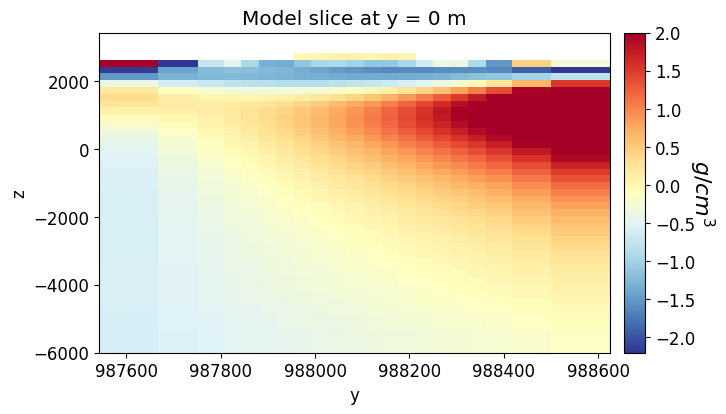

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


# norm = mpl.colors.Normalize(
#     vmin=-np.max(np.abs(recovered_tensor_model)), vmax=-np.min(np.abs(recovered_tensor_model))
#     )

norm = mpl.colors.Normalize(vmin=-2.2, vmax=2.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="x",
    ax=ax1,
    ind=int(mesh.shape_cells[0] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


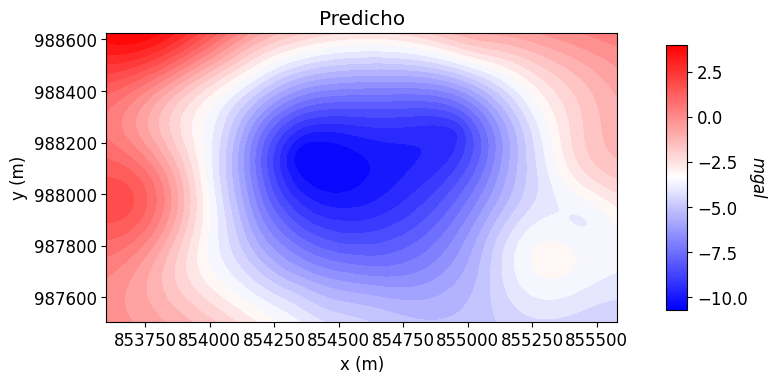

In [ ]:
#Plotear el valor predicho
dpred = (-inv_prob_L2.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred), np.max(dpred), np.min(-dpred), np.max(-dpred)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

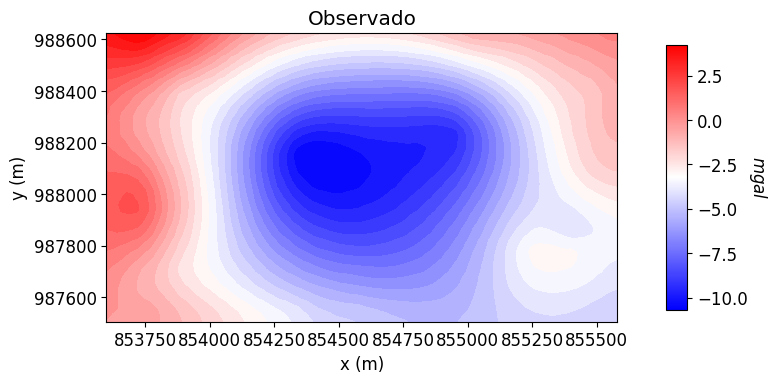

In [ ]:
#Plotear el valor observado
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

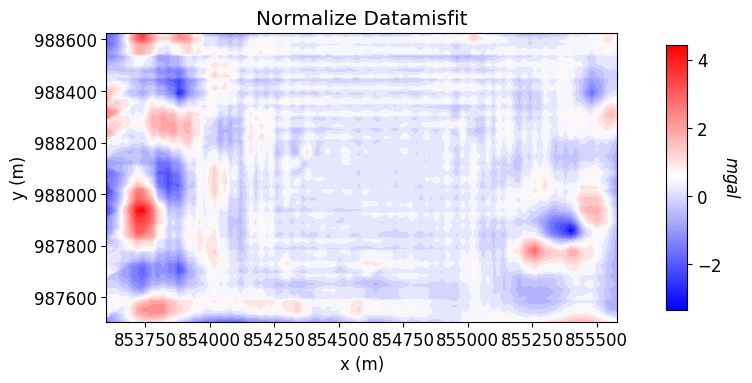

In [ ]:
data_misfit= (dobs - dpred) / uncertainties


mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit), vmax=np.max(data_misfit))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
# def plot_tikhonov_curve(iteration, scale):
#     phi_d = []
#     phi_m = []
#     beta = []
#     iterations = np.arange(len(save_iteration.outDict)) + 1
#     for kk in iterations:
#         phi_d.append(save_iteration.outDict[kk]['phi_d'])
#         phi_m.append(save_iteration.outDict[kk]['phi_m'])
#         beta.append(save_iteration.outDict[kk]['beta'])
#     fig, axs = plt.subplots(1, 2, figsize=(12,5))
#     axs[0].plot(phi_m ,phi_d, 'k.-')
#     axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=10)
#     axs[0].set_xlabel("$\phi_m$")
#     axs[0].set_ylabel("$\phi_d$")
#     axs[0].grid(True)

#     axs[1].plot(iterations, phi_d, 'k.-')
#     axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
#     ax_1 = axs[1].twinx()
#     ax_1.plot(iterations, phi_m, 'r.-')
#     ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
#     axs[1].set_ylabel("$\phi_d$")
#     ax_1.set_ylabel("$\phi_m$")
#     axs[1].set_xlabel("Iterations")
#     axs[1].grid(True)
#     axs[0].set_title(
#         "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
#         fontsize = 14
#     )
#     axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
#     for ii, ax in enumerate(axs):        
#         if ii == 0:
#             ax.set_xscale(scale)        
#         ax.set_yscale(scale)
#         xlim = ax.get_xlim()
#         ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
#         ax.set_xlim(xlim)
#     axs[0].legend()

#     plt.tight_layout()    

In [ ]:
target_misfit.target

224.87

In [ ]:
# def plot_tikhonov_curve(iteration, scale):
#     phi_d = []
#     phi_m = []
#     beta = []
#     iterations = np.arange(len(save_iteration.outDict)) + 1
#     for kk in iterations:
#         phi_d.append(save_iteration.outDict[kk]['phi_d'])
#         phi_m.append(save_iteration.outDict[kk]['phi_m'])
#         beta.append(save_iteration.outDict[kk]['beta'])
    
#     fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
#     # Primera gráfica
#     axs[0].plot(phi_m, phi_d, 'k.-')
#     axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
#     axs[0].set_xlabel("$\phi_m$")
#     axs[0].set_ylabel("$\phi_d$")
#     axs[0].grid(True)
    
#     # Segunda gráfica
#     line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
#     point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
#     ax_1 = axs[1].twinx()
#     line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
#     point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
#     axs[1].set_ylabel("$\phi_d$")
#     ax_1.set_ylabel("$\phi_m$")
#     axs[1].set_xlabel("Iterations")
#     axs[1].grid(True)
    
#     # Añadir leyendas
#     lines = line1 + line2
#     labels = [line.get_label() for line in lines]
#     axs[1].legend(lines, labels, loc='upper left')
    
#     axs[0].set_title(
#         "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
#         fontsize = 14
#     )
#     axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
#     for ii, ax in enumerate(axs):        
#         if ii == 0:
#             ax.set_xscale(scale)        
#         ax.set_yscale(scale)
#         xlim = ax.get_xlim()
#         ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
#         ax.set_xlim(xlim)
    
#     axs[0].legend()
#     plt.tight_layout()    

# interact(
#     plot_tikhonov_curve, 
#     iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1),
#     scale=widgets.RadioButtons(options=["linear", "log"])
# )

In [ ]:
# def plot_interactive_results(iteration):
#     # Calcular data misfit normalizado
#     dobs_iter = dobs
    
#     # Obtener datos predichos de la iteración específica
#     dpred_iter = save_iteration.outDict[iteration]['dpred']
    
#     # Calcular data misfit normalizado
#     data_misfit_iter = (dobs - dpred) / uncertainties
    
#     # Configurar figura
#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19, 9))

#     #Plotear el valor observado
#     plot2Ddata(
#         receiver_locations,
#         dobs_iter,
#         ax=ax0,
#         ncontour=30,
#         contourOpts={"cmap": "Spectral_r"}
#     ) 
#     ax0.set_title(f"Observado - Iteration {iteration}")
#     ax0.set_xlabel("x (m)")
#     ax0.set_ylabel("y (m)")  
    
#     # Plotear datos predichos
#     plot2Ddata(
#         receiver_locations, 
#         -dpred_iter, 
#         ax=ax1, 
#         ncontour=30, 
#         contourOpts={"cmap": "Spectral_r"}
#     )
#     ax1.set_title(f"Predicted Data - Iteration {iteration}")
#     ax1.set_xlabel("x (m)")
#     ax1.set_ylabel("y (m)")
    
#     # Plotear data misfit normalizado
#     plot2Ddata(
#         receiver_locations, 
#         data_misfit_iter, 
#         ax=ax2, 
#         ncontour=30, 
#         contourOpts={"cmap": "Spectral_r"}
#     )
#     ax2.set_title(f"Normalized Data Misfit - Iteration {iteration}")
#     ax2.set_xlabel("x (m)")
#     ax2.set_ylabel("y (m)")
    
#     plt.tight_layout()
#     plt.show()

# # Crear widget interactivo
# interact(plot_interactive_results, 
#          iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1)
# )

In [ ]:
# def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
#     # Recuperar el modelo
#     model = save_iteration.outDict[iteration]['m']

#     # Expandir el modelo si el tamaño no coincide con el total de celdas
#     if model.size != mesh.nC:
#         expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
#         expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
#     else:
#         expanded_model = model  # Usar el modelo directamente

    
#     # Crear la figura
#     fig = plt.figure(figsize=(12, 8))

#     # Calcular los límites de los colores con base en los valores del modelo
#     clim = [expanded_model.min(), expanded_model.max()]
    
#     # Usar plot_3d_slicer y obtener los cortes en los tres planos
#     mesh.plot_3d_slicer(
#         expanded_model,
#         clim=clim,
#         xslice=xslice,
#         yslice=yslice,
#         zslice=zslice,
#         fig=fig,
#         pcolor_opts={'cmap': 'Spectral_r'}
#     )
    
#     # Configurar barra de colores manualmente
#     sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
#     sm._A = []  # Esto es necesario para matplotlib
#     cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
#     cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

#     # Configurar el título
#     plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
#     plt.show()

# # Configurar widgets interactivos
# interact(
#     plot_recovered_model, 
#     iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
#     xslice=widgets.FloatText(value=854500, step=1),
#     yslice=widgets.FloatText(value=988000, step=1), 
#     zslice=widgets.FloatText(value=2000, step=1),
#     vmax=widgets.FloatText(value=0.7)
# )




In [ ]:
# import pyvista as pv

# def plot_3d_with_pyvista(model, notebook=True, threshold=0.4):
#     pv.set_plot_theme("document")
    
#     # Expandir el modelo si es necesario
#     if model.size != mesh.nC:
#         expanded_model = np.zeros(mesh.nC)  # Crear un modelo lleno de ceros para todas las celdas
#         expanded_model[:model.size] = model  # Asignar valores a las celdas activas
#     else:
#         expanded_model = model  # Usar el modelo directamente

#     # Convertir la malla a un dataset de PyVista
#     dataset = mesh.to_vtk({'Densidad': expanded_model})
    
#     # Crear la escena de renderizado
#     p = pv.Plotter(notebook=notebook)
#     p.hide_axes()  # Ocultar los ejes para una visualización más limpia
#     # p.show_grid()  # Mostrar la cuadrícula
    
#     # Filtrar por un umbral
#     threshed = dataset.threshold(-threshold, invert=True)

#     # Calcular los límites de los colores con base en los valores del modelo
#     clim = [expanded_model.min(), expanded_model.max()]

#     # Definir argumentos de la barra de colores
#     scalar_bar_args = {
#         'title': 'mGal',  # Título de la barra de colores
#         'vertical': False
#     }
    
#     # Agregar los datos volumétricos a la escena
#     dparams = dict(
#         show_edges=False,
#         cmap="Spectral_r",
#         clim=clim,
#         scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
#     )
#     p.add_mesh(threshed, **dparams)
    
#     # Ajustar la escala y la posición de la cámara
#     p.set_scale(1, 1, 0.1)
    
#     # Mostrar la escena
#     p.show(window_size=[1024, 568])

# # Llamar a la función con el modelo expandido
# plot_3d_with_pyvista(recovered_tensor_model, notebook=False, threshold=-0.6)


In [ ]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties


In [ ]:
normalized_data_misfits

array([-1.4437258 , -1.29933882, -1.14919377, ...,  0.39027441,
        0.11843149, -0.18568478])

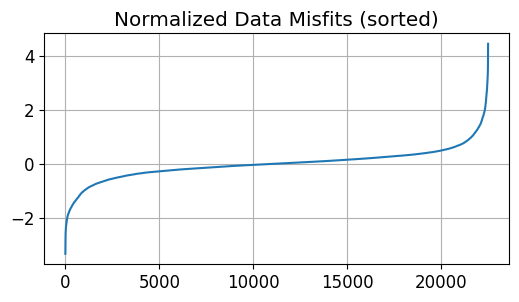

In [ ]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [ ]:
# Generate new uncertainties
new_uncertainties = np.abs(normalized_data_misfits).copy()


In [ ]:
for valor in new_uncertainties:
    print(valor)

1.4437257958786254
1.2993388227948595
1.1491937747585865
0.9929377914624933
0.8302895924333071
0.7067124296179831
0.532350311426937
0.35193552045734827
0.16646685969066446
0.03104417630045501
0.21336266607318377
0.38900849399546106
0.551907409666071
0.6956153363613554
0.69291592547722
0.7710128972356094
0.8276976268716798
0.7489717127844981
0.7857464148745698
0.6148445180299269
0.6013870150710348
0.5674979091254775
0.5134468518947798
0.4420706166407815
0.10464826513747981
0.12733035931490314
0.03748829216633785
0.05144155438804919
0.4041799171836066
0.44554160588340136
0.5307508880895714
0.7086935401434842
0.7878738711632832
1.12703276594259
1.1856006941216926
1.281486904695269
1.3031699097371174
1.2972046736566205
1.563412050417412
1.6318505467836952
1.6313097517566009
1.6206830075432002
1.6009036581034692
1.9369068716557154
1.8459070862814926
1.781847677970246
1.713164079685573
1.9501123669651008
1.8726041075156474
1.788866682074496
1.817436368719584
1.7003081185402316
1.783932224447

In [ ]:
new_uncertainties[np.abs(normalized_data_misfits) > 1.1] /= 10.0

In [ ]:
for valor in new_uncertainties:
    print(valor)

0.14437257958786254
0.12993388227948593
0.11491937747585865
0.9929377914624933
0.8302895924333071
0.7067124296179831
0.532350311426937
0.35193552045734827
0.16646685969066446
0.03104417630045501
0.21336266607318377
0.38900849399546106
0.551907409666071
0.6956153363613554
0.69291592547722
0.7710128972356094
0.8276976268716798
0.7489717127844981
0.7857464148745698
0.6148445180299269
0.6013870150710348
0.5674979091254775
0.5134468518947798
0.4420706166407815
0.10464826513747981
0.12733035931490314
0.03748829216633785
0.05144155438804919
0.4041799171836066
0.44554160588340136
0.5307508880895714
0.7086935401434842
0.7878738711632832
0.11270327659425901
0.11856006941216926
0.1281486904695269
0.13031699097371174
0.12972046736566206
0.1563412050417412
0.16318505467836952
0.16313097517566008
0.16206830075432002
0.1600903658103469
0.19369068716557153
0.18459070862814925
0.17818476779702458
0.1713164079685573
0.19501123669651008
0.18726041075156474
0.1788866682074496
0.1817436368719584
0.17003081

In [ ]:
# Generate new data object
new_data_object = data.Data(survey, dobs=dobs, standard_deviation=new_uncertainties)


In [ ]:
# import numpy as np
# from discretize import TreeMesh

# # Aumenta ligeramente los tamaños de celda mínimos
# dx = 32  # incrementado de 32 a 40
# dy = 16  # incrementado de 64 a 80
# dz = 144  # incrementado de 80 a 100

# # Define domain dimensions
# x_length = 2954.0
# y_length = 1072.0
# z_length = 7000.0

# # Compute number of base mesh cells required in x, y, and z
# nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
# nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
# nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# # Define the base mesh
# hx = [(dx, nbcx)]
# hy = [(dy, nbcy)]
# hz = [(dz, nbcz)]

# # Define starting coordinates
# x0 = [852614, 987543, -9000]

# # Create mesh
# tree_mesh = TreeMesh([hx, hy, hz], x0=x0)

# # Shift vertically to top same as maximum topography
# tree_mesh.origin += np.r_[0.0, 0.0, xyz_topo[:, -1].max()]

# # Refine based on surface topography
# tree_mesh.refine_surface(xyz_topo, padding_cells_by_level=[8, 8], finalize=False)

# # Refine box based on region of interest
# wsb_corner = np.c_[854000., 987700., -5500]
# ent_corner = np.c_[855200., 988300., 550]
# # Note -1 is a flag for smallest cell size
# tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

# # Finalize the mesh
# tree_mesh.finalize()

# # A boolean array specifying which cells lie on the boundary
# bInd = tree_mesh.cell_boundary_indices

# # Cell volumes
# v = tree_mesh.cell_volumes

# fig = plt.figure(figsize=(7, 4))
# ax = fig.add_subplot(111)
# tree_mesh.plot_slice(
#     np.log10(v),
#     normal="Y",
#     ax=ax,
#     ind=int(tree_mesh.h[1].size / 2),
#     grid=True)
# ax.set_ylim(-6000, 3000)
# ax.set_title("Cell Log-Volumes at Y = 0 m")

<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

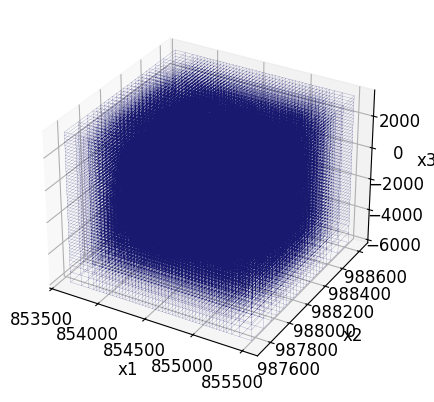

In [ ]:
#definir la malla
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
tree_mesh = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])

                           
tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)

In [ ]:
active_tree_cells = active_from_xyz(tree_mesh, xyz_topo)
n_tree_active = int(active_tree_cells.sum())

In [ ]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [ ]:
# sphere_density_new = -0.2
block_density = -0.2
starting_tree_model = 1e-4 * np.ones(n_tree_active)

In [ ]:
starting_tensor_model
ind_block = (
    (tree_mesh.gridCC[active_tree_cells, 0] > 854236)
    & (tree_mesh.gridCC[active_tree_cells, 0] < 855090)
    & (tree_mesh.gridCC[active_tree_cells, 1] > 987813)
    & (tree_mesh.gridCC[active_tree_cells, 1] < 988145)
    & (tree_mesh.gridCC[active_tree_cells, 2] > -2100)
    & (tree_mesh.gridCC[active_tree_cells, 2] < 3000)
)
starting_tree_model[ind_block] = block_density

reference_tree_model = np.zeros_like(starting_tree_model)

In [ ]:
# # starting_tensor_model

# ind_sphere = model_builder.get_indices_sphere(
#     np.r_[854536, 987813, -2000], 500.0, tree_mesh.gridCC
# )
# ind_sphere = ind_sphere[active_tree_cells]
# starting_tree_model[ind_sphere] = sphere_density_new

# reference_tree_model = np.zeros_like(starting_tree_model)

In [ ]:
tree_plotting_map = maps.InjectActiveCells(tree_mesh, active_tree_cells, np.nan)

In [ ]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey, 
    mesh=tree_mesh, 
    # rho=None,    
    rhoMap=tree_model_map,
    ind_active=active_tree_cells,
    engine="geoana",
    )

In [ ]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)


In [ ]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=dz**-0.1,
    alpha_x=0.1,
    alpha_y=0.1,
    alpha_z=10,
    reference_model=starting_tree_model,
    reference_model_in_smooth=True,
    norms=[0, 2, 2, 2],
)

In [ ]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.5, upper=1.5, maxIterLS=30, maxIterCG=10, tolCG=1e-4
)
# opt_irls = optimization.InexactGaussNewton(maxIter=40)

In [ ]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [ ]:
from simpeg import directives

save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True, 
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=20)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=3.0,
    coolingRate=1,
    chifact_start=1.0,
    f_min_change=1e-4,
    max_irls_iterations=50,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
    save_iteration_new
]



In [ ]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.41e+05  9.96e+11  0.00e+00  9.96e+11    2.96e+02      0              
   1  1.14e+05  4.20e+11  6.46e+05  4.94e+11    2.82e+02      0              
   2  3.79e+04  1.76e+11  1.88e+06  2.47e+11    2.72e+02      0   Skip BFGS  
   3  1.26e+04  7.46e+10  3.34e+06  1.17e+11    2.65e+02      0   Skip BFGS  
   4  4.21e+03  3.96e+10  4.91e+06  6.03e+10    2.63e+02      0   Skip BFGS  
   5  1.40e+03  1.99e+10  7.63e+06  3.06e+10    2.65e+02      0   Skip BFGS  
   6  4.68e+02  9.84e+

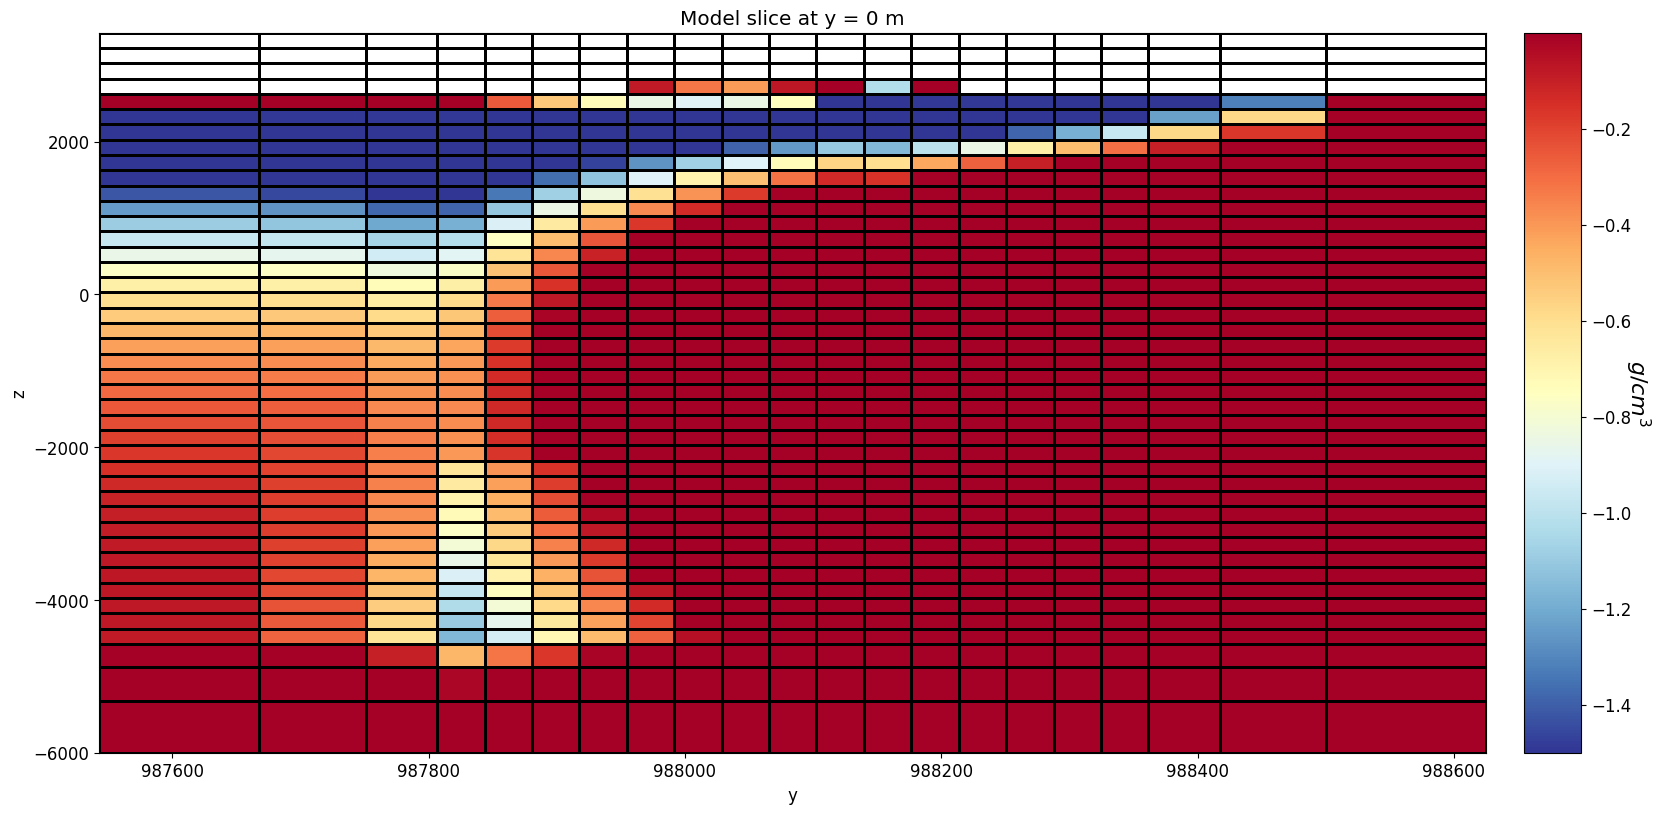

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(recovered_tree_model)), vmax=-np.min(np.abs(recovered_tree_model))
    )

# norm = mpl.colors.Normalize(vmin=-2.7, vmax=2.2)

tree_mesh.plot_slice(
    tree_plotting_map * -recovered_tree_model,
    normal="x",
    ax=ax1,
    ind=int(tree_mesh.shape_cells[0] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# plt.savefig('65_1,1,1,1_0001.png', dpi=300)

plt.show()

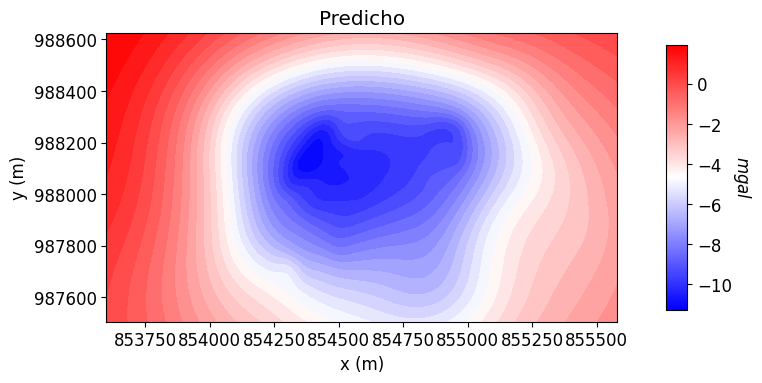

In [ ]:
dpred_new = (inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

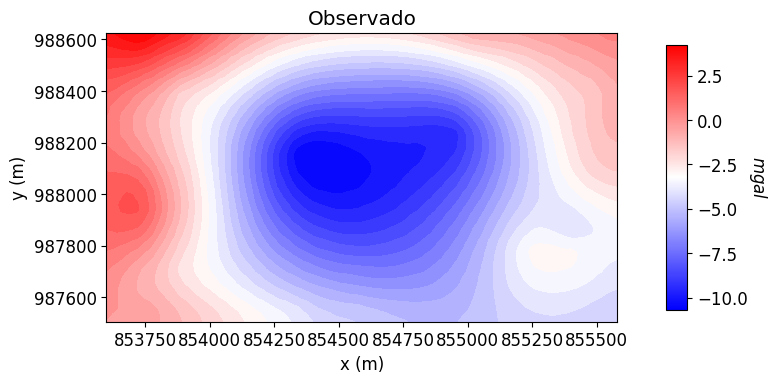

In [ ]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

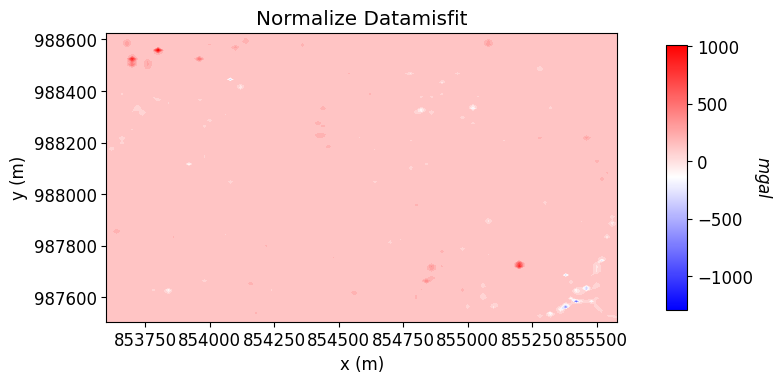

In [ ]:
data_misfit_new= (dobs - dpred_new) / new_uncertainties

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
g

NameError: name 'g' is not defined

In [ ]:
# def plot_tikhonov_curve(iteration, scale):
#     phi_d = []
#     phi_m = []
#     beta = []
#     iterations = np.arange(len(save_iteration_new.outDict)) + 1
#     for kk in iterations:
#         phi_d.append(save_iteration_new.outDict[kk]['phi_d'])
#         phi_m.append(save_iteration_new.outDict[kk]['phi_m'])
#         beta.append(save_iteration_new.outDict[kk]['beta'])
    
#     fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
#     # Primera gráfica
#     axs[0].plot(phi_m, phi_d, 'k.-')
#     axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
#     axs[0].set_xlabel("$\phi_m$")
#     axs[0].set_ylabel("$\phi_d$")
#     axs[0].grid(True)
    
#     # Segunda gráfica
#     line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
#     point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
#     ax_1 = axs[1].twinx()
#     line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
#     point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
#     axs[1].set_ylabel("$\phi_d$")
#     ax_1.set_ylabel("$\phi_m$")
#     axs[1].set_xlabel("Iterations")
#     axs[1].grid(True)
    
#     # Añadir leyendas
#     lines = line1 + line2
#     labels = [line.get_label() for line in lines]
#     axs[1].legend(lines, labels, loc='upper left')
    
#     axs[0].set_title(
#         "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
#         fontsize = 14
#     )
#     axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
#     for ii, ax in enumerate(axs):        
#         if ii == 0:
#             ax.set_xscale(scale)        
#         ax.set_yscale(scale)
#         xlim = ax.get_xlim()
#         ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
#         ax.set_xlim(xlim)
    
#     axs[0].legend()
#     plt.tight_layout()    

# interact(
#     plot_tikhonov_curve, 
#     iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1),
#     scale=widgets.RadioButtons(options=["linear", "log"])
# )

interactive(children=(IntSlider(value=1, description='iteration', max=20, min=1), RadioButtons(description='sc…

<function __main__.plot_tikhonov_curve(iteration, scale)>

In [ ]:
target_misfit.target

48.0

In [ ]:
def plot_interactive_results(iteration):
    # Calcular data misfit normalizado
    dobs_iter = dobs
    
    # Obtener datos predichos de la iteración específica
    dpred_iter = save_iteration_new.outDict[iteration]['dpred']
    
    # Calcular data misfit normalizado
    data_misfit_iter = (dobs - dpred_new) / uncertainties
    
    # Configurar figura
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19, 9))

    #Plotear el valor observado
    plot2Ddata(
        receiver_locations,
        dobs_iter,
        ax=ax0,
        ncontour=30,
        contourOpts={"cmap": "Spectral_r"}
    ) 
    ax0.set_title(f"Observado - Iteration {iteration}")
    ax0.set_xlabel("x (m)")
    ax0.set_ylabel("y (m)")  
    
    # Plotear datos predichos
    plot2Ddata(
        receiver_locations, 
        dpred_iter, 
        ax=ax1, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax1.set_title(f"Predicted Data - Iteration {iteration}")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    
    # Plotear data misfit normalizado
    plot2Ddata(
        receiver_locations, 
        data_misfit_iter, 
        ax=ax2, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax2.set_title(f"Normalized Data Misfit - Iteration {iteration}")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    
    plt.tight_layout()
    plt.show()

# Crear widget interactivo
interact(plot_interactive_results, 
         iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1)
)

interactive(children=(IntSlider(value=1, description='iteration', max=20, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_interactive_results(iteration)>

In [ ]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo (asegurándonos de que es el correcto)
    model = save_iteration_new.outDict[iteration]['m']
    
    # Si el modelo tiene más celdas de las que tiene la malla, recortarlo
    if model.size > mesh.nC:
        model = model[:mesh.nC]  # Recortar el modelo a las celdas de la malla

    # Si el modelo tiene menos celdas que la malla, expandirlo (debe alinearse con las celdas activas de la malla)
    if model.size < mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
        model = expanded_model  # Usar el modelo expandido

    # Crear la figura para visualizar
    fig = plt.figure(figsize=(10, 10))

    # Graficar usando el modelo ajustado
    mesh.plot_3d_slicer(
        model,  # Usar el modelo ajustado
        clim=(0, vmax),
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

        # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()
    
    # # Configurar etiquetas
    # plt.title(f'Recovered Model - Iteration {iteration}')
    # plt.colorbar(label='Density (g/cm³)')

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
    xslice=widgets.FloatText(value=854000, step=200),
    yslice=widgets.FloatText(value=988000, step=200), 
    zslice=widgets.FloatText(value=-2000, step=200),
    vmax=widgets.FloatText(value=0.7)
)


interactive(children=(IntSlider(value=1, description='iteration', max=10, min=1), FloatText(value=854000.0, de…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>

In [ ]:
models = {'Densidad':tensor_plotting_map*recovered_tree_model}
databse = mesh.to_vtk(models)

ValueError: Dimension mismatch in InjectActiveCells(41538,37538) and np.ndarray(132151,).

In [ ]:
databse.save('modelo_t_tree.vtk')

In [ ]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo
    model = save_iteration.outDict[iteration]['m']

    # Expandir el modelo si el tamaño no coincide con el total de celdas
    if model.size != mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
    else:
        expanded_model = model  # Usar el modelo directamente

    
    # Crear la figura
    fig = plt.figure(figsize=(12, 8))

    # Calcular los límites de los colores con base en los valores del modelo
    clim = [expanded_model.min(), expanded_model.max()]
    
    # Usar plot_3d_slicer y obtener los cortes en los tres planos
    mesh.plot_3d_slicer(
        expanded_model,
        clim=clim,
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    
    # Configurar barra de colores manualmente
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

    # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
    xslice=widgets.FloatText(value=854500, step=1),
    yslice=widgets.FloatText(value=988000, step=1), 
    zslice=widgets.FloatText(value=2000, step=1),
    vmax=widgets.FloatText(value=0.7)
)


interactive(children=(IntSlider(value=1, description='iteration', max=10, min=1), FloatText(value=854500.0, de…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>